In [0]:
import itertools
import pickle
import random
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [1]:
PATH = ""

In [0]:
# Игровое поле
class GameBoard:
    def __init__(self):        
        self.reset()
        
    def reset(self):
        self.board = np.zeros((3, 3)).astype(int)
        self.done = False
        self.X_reward = 0.
        self.O_reward = 0.
    
    def set_sign(self, coords, sign):
        # Выполняет ход, если возможно
        assert(type(coords) is tuple and len(coords)==2)
        if self.board[coords] != 0:
            return False
        if sign==1 or sign==-1:
            self.board[coords] = sign
            return True
        return False
    
    def get_state(self):
        return self.board
    
    def get_actions(self):
        # Возвращает допустимые действия
        return np.argwhere(self.board==0)
    
    def check_win(self, sign, state=None):
        # Проверяет выигрыш игрока
        if state is None:
            state = self.board
        win = False
        if np.any(np.sum(state, axis=0) == 3*sign) or np.any(np.sum(state, axis=1) == 3*sign) \
        or np.trace(state) == 3*sign or np.trace(np.rot90(state)) == 3*sign :
            win = True        
        return win
    
    def check_draw(self):
        # Проверяет ничью
        if 0 not in self.board:
            return True
    
    def check_done(self):
        # Проверяет завершение партии
        if self.check_win(1):
            #print("X won")
            self.X_reward = 1.
            self.O_reward = 0.
            self.done = True
        if self.check_win(-1):
            #print("O won")
            self.O_reward = 1.
            self.X_reward = 0.
            self.done = True
        if self.check_draw():
            #print("Draw")
            self.X_reward = 0.5
            self.O_reward = 0.5
            self.done = True        
        return self.done
    
    def get_reward(self, player):
        # Возвращает награду
        if player.sign == 1:
            return self.X_reward
        if player.sign == -1:
            return self.O_reward
    
    def print(self):
        # Печатает поле
        sign = lambda x: "X" if x == 1 else "O" if x == -1 else " "
        print("  0 1 2 ")
        print("  - - - ")
        print("0|{}|{}|{}|".format(sign(self.board[0,0]), sign(self.board[0,1]), sign(self.board[0,2])))
        print("  - - - ")
        print("1|{}|{}|{}|".format(sign(self.board[1,0]), sign(self.board[1,1]), sign(self.board[1,2])))
        print("  - - - ")
        print("2|{}|{}|{}|".format(sign(self.board[2,0]), sign(self.board[2,1]), sign(self.board[2,2])))
        print("  - - - ")
        

In [0]:
"""
Класс игрока.
Включает бот для игры, стремящийся поставить три в ряд и
блокирующий такие попытки оппонента. Пытается вилки делать.
Простенький, но играть может.
"""
class Player:
    def __init__(self, board, side="X"):
        self.board = board
        self.sign = 1 if side=="X" else -1 if side=="O" else 0
            
    def __check_danger(self, coords, sign, state):  
        # Проверяет опасную ситуацию      
        c0 = coords[0]
        c1 = coords[1]        
        if (state[c0, :]==-sign).sum()==2:
            return True
        if (state[:, c1]==-sign).sum()==2:
            return True        
        if c0==1 and c1==1:
            if np.trace(state) == -2*sign or np.trace(np.rot90(state))==-2*sign:
                return True
        elif c0==c1:            
            if np.trace(state) == -2*sign:
                return True
        elif np.abs(c0-c1)==2:            
            if np.trace(np.rot90(state))==-2*sign:
                return True        
        return False
    
    def __find_danger(self, sign, state):         
        return np.argwhere(state==0)[np.array([self.__check_danger(c, sign, state) for c in self.get_actions(state)])]
    
    def get_actions(self, state):
        return np.argwhere(state==0)
    
    def make_move(self, coords):
        # Для совершения хода вручную
        if self.board.check_done():
            return False
        if self.board.set_sign(coords, self.sign):
            self.board.check_done()
            return True
        print("Invalid move")
        return False
    
    def act(self):
        # Совершение хода ботом
        if self.board.check_done():
            return False
        wins = self.__find_danger(-self.sign, self.board.get_state())
        if len(wins) > 0:
            self.make_move(tuple(wins[0]))
            return True
        dangers = self.__find_danger(self.sign, self.board.get_state())
        if len(dangers) > 0:
            self.make_move(tuple(dangers[0]))
            return True
        actions = self.get_actions(self.board.get_state())
        if [1, 1] in actions.tolist():            
            self.make_move((1, 1))
            return True
        else:
            potential = 0
            action = actions[np.random.randint(len(actions))]
            for a in actions:                
                test_state = self.board.get_state().copy()
                test_state[tuple(a)] = self.sign
                if len(self.__find_danger(sign=-self.sign, state=test_state)) > potential:
                    potential = len(self.__find_danger(sign=-self.sign, state=test_state))
                    action = a
                    #print(a)
            self.make_move(tuple(action))        
        return True

In [0]:
gb = GameBoard()
pla = Player(gb)
bot = Player(gb, "O")
gb.print()

  0 1 2 
  - - - 
0| | | |
  - - - 
1| | | |
  - - - 
2| | | |
  - - - 


In [0]:
# Можно поиграть вручную, задавая коордтнаты в make_move()
if(pla.make_move((1,1))):
    gb.print()
    print(gb.get_reward(pla))
    if(bot.act()):
        gb.print()
        print(gb.get_reward(bot))

  0 1 2 
  - - - 
0| | | |
  - - - 
1| |X| |
  - - - 
2| | | |
  - - - 
0.0
  0 1 2 
  - - - 
0| |O| |
  - - - 
1| |X| |
  - - - 
2| | | |
  - - - 
0.0


In [0]:
# Класс таблицы Q(s,a)
class QTable:
    def __init__(self):
        self.__generate_positions()
        self.all_actions = np.array([p for p in itertools.product(range(3), repeat=2)])
        self.__generate_table()    
    
    def __generate_positions(self):
        # Создает список всех возможных позиций.
        positions = []
        for i, c in enumerate(itertools.product(range(3), repeat=9)):
            c = np.array(c)-1  
            # Количество крестиков и ноликов на доске должно быть равно
            if (c==1).sum() == (c==-1).sum():
                c = c.reshape([3,3])                
                # Не должно быть выигрышных позиций
                if not GameBoard().check_win(1, c) and not GameBoard().check_win(-1, c):
                    positions.append(c)
        self.positions = np.array(positions).astype(int)
    
    def __generate_table(self):
        # Создает q-таблицу с нулями
        self.table = np.zeros((9, len(self.positions)))        
    
    def patois(self, plaa):
        # Возвращает индексы доступных игроку действий
        return np.array([np.where(np.all(self.all_actions==plaa[i], axis=1))[0][0] for i in range(len(plaa))])
    
    def atoi(self, action):
        # Возвращает индекс действия
        return np.where(np.all(self.all_actions==action, axis=1))[0][0]
    
    def stoi(self, state):
        # Возвращает индекс состояния
        return np.where(np.all(self.positions == state, axis=(1,2)))[0][0]
    
    def get_states(self):
        # Возвращает все позиции
        return self.positions
    
    def get_table(self):
        # Возвращает таблицу
        return self.table
    
    def get_all_actions(self):
        # Возвращает все действия
        return self.all_actions
    
    def get_Q(self, state, action):
        # Возвращает Q(s,a)
        si = self.stoi(state)
        ai = self.atoi(action)
        return self.table[ai, si]
    
    def set_Q(self, state, action, value):
        # Устанавливает Q(s,a)
        si = self.stoi(state)
        ai = self.atoi(action)        
        self.table[ai, si] = value
        
    def get_Qs(self, state):
        # Возвращает значения Q для всех действий при состоянии
        si = self.stoi(state)        
        return self.table[:, si]
    
    def save(self):
        with open(os.path.join(PATH, "qtable.pickle"), "wb") as f:
            pickle.dump(self.table, f)
            
    def load(self):
        with open(os.path.join(PATH, "qtable.pickle"), "rb") as f:
            self.table = pickle.load(f)

In [0]:
# Табличная модель reinforcement learning
class RLTDmodel:
    def __init__(self, player, gameboard, qtable):
        self.alpha = 0.1
        self.gamma = 0.9
        self.epsilon = 0.1        
        self.r = 0.
        self.player = player
        self.gameboard = gameboard
        self.Qtable = qtable
        self.prev_a = None
        self.prev_s = None    
    
    def select_action(self):
        # Выбор действия через epsilon-greedy стратегию
        state = self.gameboard.get_state()
        actions = self.player.get_actions(state)
        if np.random.rand() < self.epsilon:
            return actions[np.random.randint(len(actions))]
        else:                        
            Qs = np.array([self.Qtable.get_Q(state, action) for action in actions])
            return actions[np.argmax(Qs)]
        
    def act(self):
        self.r = 0.
        a = self.select_action()
        self.prev_a = a
        self.prev_s = self.gameboard.get_state().copy()        
        self.player.make_move(tuple(a))        
        
    def get_reward(self):
        self.r = gb.get_reward(self.player)

    def update_Qs(self):
        # Обновление Q по уравнению Беллмана
        state = self.gameboard.get_state()
        actions = self.player.get_actions(state)        
        Q_old = self.Qtable.get_Q(self.prev_s, self.prev_a)
        if not self.gameboard.done:
            Q_max = np.max(np.array([self.Qtable.get_Q(state, action) for action in actions]))            
        else:
            Q_max = 0.            
        Q_new = Q_old + self.alpha*(self.r + self.gamma*Q_max - Q_old)        
        self.Qtable.set_Q(self.prev_s, self.prev_a, Q_new)

In [0]:
# Обучение модели.
def train_qtable(num_iterations, start_epsilon, final_epsilon):
    Xr = 0
    Or = 0
    Dr = 0
    for i in range(num_iterations):
        if i>1 and i % 10000 == 0:
            qt.save()
            print("Results {} :".format(i), Xr, Dr, Or, str(100*Xr/(Xr+Or))+"%")
            Xr = 0
            Or = 0
            Dr = 0
        gb.reset()
        # Уменьшение epsilon по мере обучения
        rtm.epsilon = final_epsilon + (start_epsilon - final_epsilon)*((num_iterations - i)/num_iterations)
        while not gb.done:
            # Ход модели
            rtm.act()            
            if gb.done:
                # Если терминальное состояние, получение награды (бот уже ходить не будет)
                rtm.get_reward()
                # Обновление таблицы
                rtm.update_Qs()
                if rtm.r == 1.:
                    Xr += 1
                if rtm.r == 0.1:
                    Dr += 1
            if(bot.act()):
                # После хода бота, получение награды,
                rtm.get_reward()            
                # Обновление таблицы
                rtm.update_Qs()
                if gb.get_reward(bot) == 1.:
                    Or += 1
    print("Results", Xr, Dr, Or, str(100*Xr/(Xr+Or))+"%")

In [0]:
# Обучение
qt = QTable()
gb = GameBoard()
pla = Player(gb)
bot = Player(gb, "O")
rtm = RLTDmodel(pla, gb, qt)
train_qtable(100000, 0.1, 0.01)

Results 10000 : 9 7346 2645 0.33911077618688773%
Results 20000 : 25 7899 2076 1.1899095668729176%
Results 30000 : 1418 6370 2212 39.0633608815427%
Results 40000 : 4109 4516 1375 74.927060539752%
Results 50000 : 4211 4863 926 81.97391473622737%
Results 60000 : 4385 4905 710 86.06476938174681%
Results 70000 : 4393 4979 628 87.49253136825334%
Results 80000 : 4570 4966 464 90.78267779102106%
Results 90000 : 4694 4935 371 92.67522211253701%
Results 4731 5078 191 96.11946363266965%


In [0]:
def plot_qs(qt, num=(2,2), p=None):
    positions_to_plot = np.random.choice(np.arange(qt.positions.shape[0]), size=num, replace=False, p=p)
    fig, ax = plt.subplots(*num, figsize=(num[1]*2.1,num[0]*2.5))
    ticks = np.arange(3)
    for a0, a1 in itertools.product(range(num[0]), range(num[1])):
        pos = qt.positions[positions_to_plot[a0, a1]]
        qs = qt.get_Qs(pos).reshape(3, 3)
        ax[a0][a1].imshow(qs, interpolation="nearest", cmap="Reds", vmin=0, vmax=1)        
        ax[a0][a1].set_xticks(ticks)
        ax[a0][a1].xaxis.tick_top()
        ax[a0][a1].set_yticks(ticks)
        for i, j in itertools.product(range(3), range(3)):
            if pos[i,j] == 0:
                ax[a0][a1].text(j, i, "{:.3f}".format(qs[i, j]),
                         horizontalalignment = "center",
                         verticalalignment = "center",
                         color = "white" if qs[i, j] > 0.5 else "black", alpha=0.5)
            else:
                ax[a0][a1].text(j, i, "X" if pos[i,j]==1 else "O",
                         horizontalalignment = "center",
                         verticalalignment = "center",
                         color = "white" if qs[i, j] > 0.5 else "black")

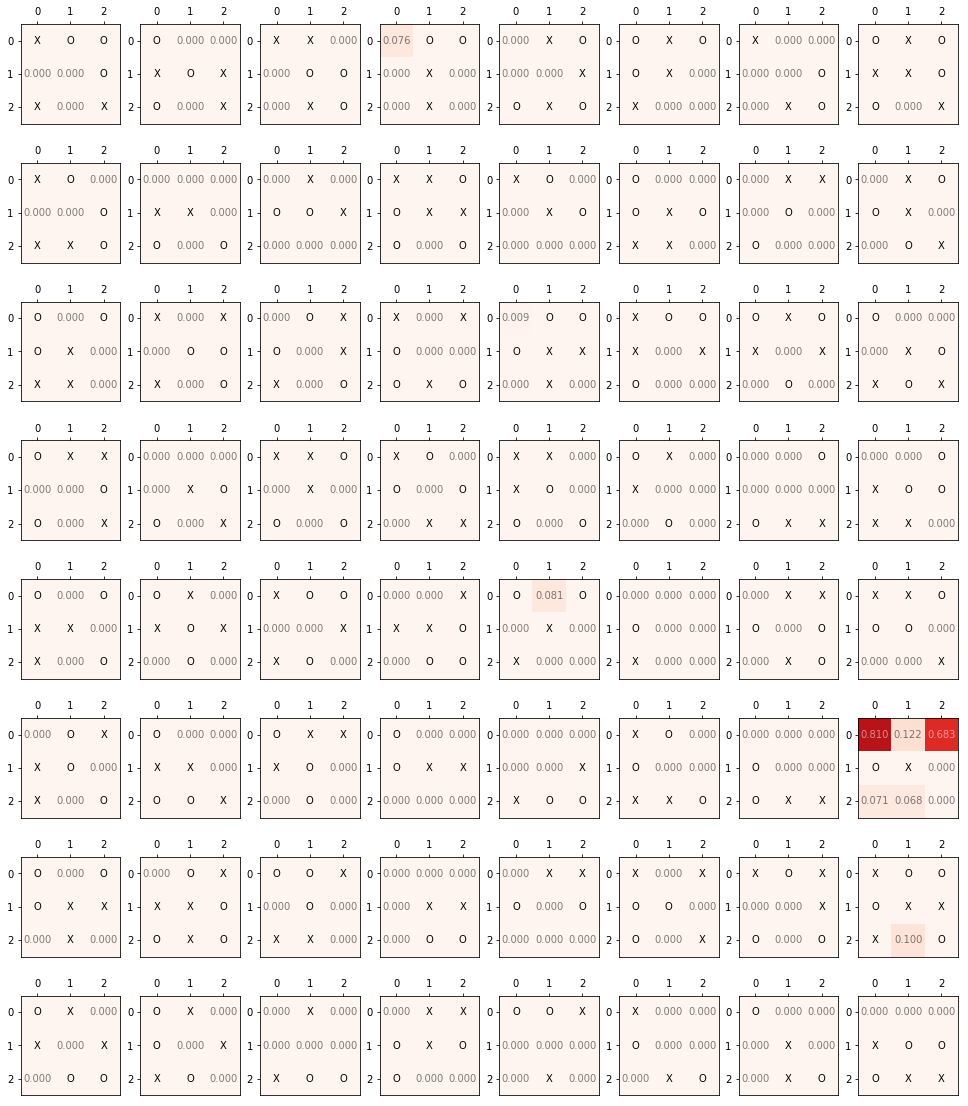

In [0]:
# Визуализация Q значений по позициям
plot_qs(qt, num=(8,8))

Видно, что в процессе обучения модели попадалось не очень много вариантов позиций. Ниже показаны "самые выученные" ходы. Модель натренировалась занимать центр на первом ходу (1 ряд, 5 колонка), блокировать (1 ряд, 3 колонка), умеет делать "вилки" (1 ряд, 8 колонка).

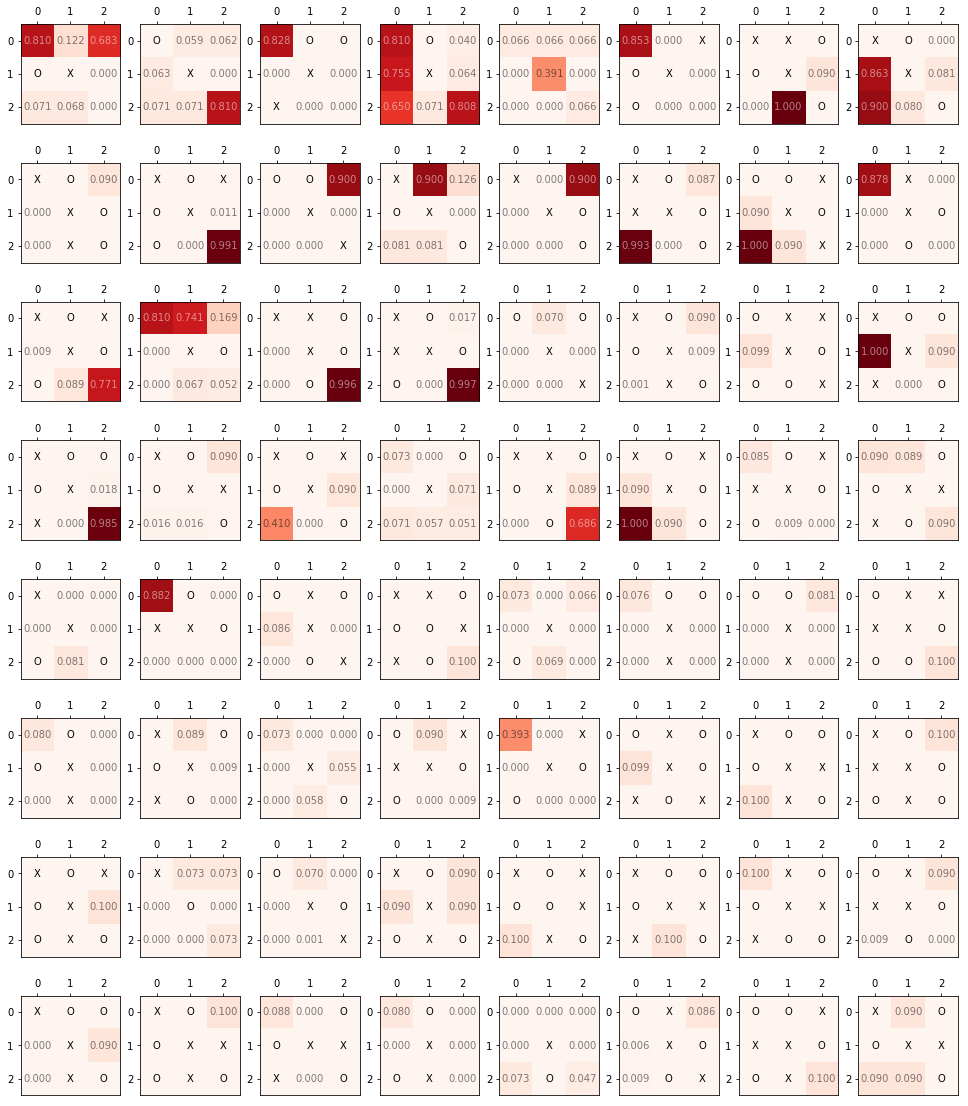

In [0]:
plot_qs(qt, num=(8,8), p=qt.table.sum(axis=0)/qt.table.sum())

In [0]:
# Обертка для игры для обучения нейросети. По ходу игрока возвращает следующее
# состояние (после хода оппонента), награду, конец игры.
class Game:
    def __init__(self):
        self.gb = GameBoard()
        self.pla = Player(self.gb)
        self.bot = Player(self.gb, "O")
        self.actions_all = self.gb.get_actions()
        self.actions_n = len(self.actions_all)
    
    def atoi(self, action):
        return np.where(np.all(self.actions_all==action, axis=1))[0][0]
    
    def actions_valid_mask(self, state):
        mask = np.zeros((1, 9))
        v = self.pla.get_actions(state)
        for v in v:
            mask += np.all(self.actions_all==v, axis=1).astype(int)
        return mask.astype(bool)         
        
    def step(self, action):
        reward = 0.
        action = self.actions_all[np.array(action).astype(bool)][0]        
        self.pla.make_move(tuple(action))
        terminal = self.gb.done
        # Получение награды либо в терминальном состоянии, либо после хода бота
        if terminal:
            reward = self.gb.get_reward(self.pla)        
        else:
            self.bot.act()
            reward = self.gb.get_reward(self.pla)
            terminal = self.gb.done
        state = self.gb.get_state().copy()
        return state, reward, terminal

In [0]:
param_input_shape = 9
param_n_actions = 9
param_loss_fn = F.mse_loss
param_gamma = 0.99
param_epsilon = 0.1
param_iterations = 200001
param_replay_memory_size = 4096
param_batch_size = 1024

In [0]:
# FullyConnected с маской
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, 
                 last_fn=None, first_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x, mask=None):        
        if self.flatten:
            x = x.view(x.shape[0], -1)  
        # Clamp для маскирования
        x = torch.clamp(self.model(x), min=0.001)
        # Маскирование невозможных действий нулями
        if mask is not None:
            x = x*mask.float()
        return x

In [0]:
# Создание "policy net" и "target net"
dqn = FullyConnected([param_input_shape, 128, 256, 128, param_n_actions],
                     flatten=True, dropout=False, activation_fn=nn.LeakyReLU(0.2), last_fn=nn.ReLU(), device=device)

dqn_opt = optim.Adam(dqn.parameters(), lr=1e-5)

dqn_target = FullyConnected([param_input_shape, 128, 256, 128, param_n_actions],
                     flatten=True, dropout=False, activation_fn=nn.LeakyReLU(0.2), last_fn=nn.ReLU(), device=device)
dqn_target.load_state_dict(dqn.state_dict())
dqn_target.eval()

dqn_train_log = {'DQN': []}
dqn_test_log = {'DQN': []}

In [0]:
load_filename = "model_128_256_128_relu_start_v4_2_200000.pth"
filename = "model_128_256_128_relu_start_v4_3_{}.pth"

In [0]:
# Горячий старт
dqn = FullyConnected([param_input_shape, 128, 256, 128, param_n_actions],
                     flatten=True, dropout=False, activation_fn=nn.LeakyReLU(0.2), last_fn=nn.ReLU(), device=device)

dqn.load_state_dict(torch.load(os.path.join(PATH, load_filename), map_location=device))
dqn_opt = optim.Adam(dqn.parameters(), lr=1e-5)

dqn_target = FullyConnected([param_input_shape, 128, 256, 128, param_n_actions],
                     flatten=True, dropout=False, activation_fn=nn.LeakyReLU(0.2), last_fn=nn.ReLU(), device=device)
dqn_target.load_state_dict(dqn.state_dict())
dqn_target.eval()

dqn_train_log = {'DQN': []}
dqn_test_log = {'DQN': []}

In [0]:
replay_memory = []

In [0]:
# Обучение
for epoch in range(param_iterations):
    g = Game()
    # Прохождение игры против бота для заполнения replay memory
    while not g.gb.done:
        dqn.eval()
        state_0 = torch.Tensor(g.gb.get_state().copy()).unsqueeze(0)
        action = torch.zeros((1, param_n_actions))
        if np.random.rand() < param_epsilon:
            output = torch.rand((1,9))    
            mask = torch.Tensor(g.actions_valid_mask(state_0.squeeze().numpy())).type(torch.uint8).to(device)
            output[~mask] = 0
        else:
            mask =  (state_0 == 0).view(1, -1)
            output = dqn(state_0.to(device), mask)        
        action[:, torch.argmax(output)] = 1
        state_1, reward, terminal = g.step(action[0].numpy())
        state_1 = torch.Tensor(state_1).unsqueeze(0).to(device)
        reward = torch.Tensor([reward]).unsqueeze(0).to(device)
        terminal = torch.Tensor([terminal]).type(torch.uint8).unsqueeze(0).to(device)

        replay_memory.append((state_0, action, reward, state_1, terminal))
        if len(replay_memory) > param_replay_memory_size:
            replay_memory.pop(0)
    
    # Обучение сэмплированным батчем из replay memory
    if len(replay_memory) > param_batch_size:
        dqn.train()
        dqn.zero_grad()
        batch = random.sample(replay_memory, param_batch_size)
    
        # Разделение батча на признаки
        batch_state_0 = torch.cat(tuple(d[0] for d in batch)).to(device)
        batch_action = torch.cat(tuple(d[1] for d in batch)).to(device)
        batch_reward = torch.cat(tuple(d[2] for d in batch)).to(device)
        batch_state_1 = torch.cat(tuple(d[3] for d in batch)).to(device)
        batch_terminal = torch.cat(tuple(d[4] for d in batch)).to(device)
    
        # Предсказание target net Q значений следующего состояниz
        batch_mask_1 = (batch_state_1 == 0)
        batch_mask_1 = batch_mask_1.view((param_batch_size, -1)).to(device)
        output_1 = dqn_target(batch_state_1, batch_mask_1)        
    
        # Создание "groun truth" меток (r(s,a) + gamma*max(Q(s',a)))
        batch_y = torch.cat(tuple(batch_reward[i] if batch_terminal[i] else batch_reward[i] + \
                                  param_gamma*torch.max(output_1[i]) for i in range(len(batch))))        

        # Получение Q текущего состояния для функции потерь
        batch_mask_0 = (batch_state_0 == 0)
        batch_mask_0 = batch_mask_0.view((param_batch_size, -1)).to(device)
        output_0 = dqn(batch_state_0, batch_mask_0) 

        # Значение Q, по которому было совершено действие
        batch_q = torch.sum(output_0*batch_action, dim=1)        
        
        batch_y = batch_y.detach()
        loss = param_loss_fn(batch_q, batch_y)        

        loss.backward()
        
        for param in dqn.parameters():
            param.grad.data.clamp_(-1, 1)
        dqn_opt.step()

        if epoch % 1000 == 0:
            # Обновление весов target net
            dqn_target.load_state_dict(dqn.state_dict())
            # Вывод результатов
            res = torch.cat(tuple([d[2] for d in replay_memory[-1000:] if d[4]]))
            res = torch.sum(res)/len(res)
            wins = len([d[2] for d in replay_memory[-1000:] if d[2]==1])
            draws = len([d[2] for d in replay_memory[-1000:] if d[2]==0.5])
            losses = len([d[2] for d in replay_memory[-1000:] if (d[2]==0 and d[4])])
            print("Epoch {} loss: {}, reward ratio: {:.3f}, wins: {}, draws: {}, losses {}".format(epoch, loss.item(), res, wins, draws, losses))
            if epoch % 10000 == 0:
                torch.save(dqn.state_dict(), os.path.join(PATH, filename.format(epoch)))

Epoch 1000 loss: 0.008306697010993958, reward ratio: 0.033, wins: 9, draws: 3, losses 305
Epoch 2000 loss: 0.01761963590979576, reward ratio: 0.219, wins: 4, draws: 103, losses 147
Epoch 3000 loss: 0.01687302440404892, reward ratio: 0.324, wins: 27, draws: 104, losses 113
Epoch 4000 loss: 0.015805011615157127, reward ratio: 0.361, wins: 30, draws: 111, losses 96
Epoch 5000 loss: 0.025891197845339775, reward ratio: 0.375, wins: 27, draws: 120, losses 85
Epoch 6000 loss: 0.02629573456943035, reward ratio: 0.335, wins: 32, draws: 99, losses 112
Epoch 7000 loss: 0.03599411994218826, reward ratio: 0.402, wins: 34, draws: 117, losses 79
Epoch 8000 loss: 0.0376504622399807, reward ratio: 0.401, wins: 36, draws: 115, losses 82
Epoch 9000 loss: 0.021196335554122925, reward ratio: 0.316, wins: 26, draws: 101, losses 115
Epoch 10000 loss: 0.023839229717850685, reward ratio: 0.475, wins: 112, draws: 27, losses 125
Epoch 11000 loss: 0.009593060240149498, reward ratio: 0.543, wins: 126, draws: 28, l

Оценка игры сети при эпсилоне, равном 0. Выигрывает против бота в 100% случаев.

In [0]:
dqn.eval()
Xr = 0
Or = 0
Dr = 0
for epoch in range(1000):
    g = Game()    
    while not g.gb.done:        
        state_0 = torch.Tensor(g.gb.get_state().copy()).unsqueeze(0)
        action = torch.zeros((1, param_n_actions))                
        mask =  (state_0 == 0).view(1, -1)
        output = dqn(state_0.to(device), mask)        
        action[:, torch.argmax(output)] = 1
        state_1, reward, terminal = g.step(action[0].numpy())
        
    if reward == 1.:
        Xr += 1
    elif reward == 0.5:
        Dr += 1
    else:
        Or += 1
        
print("Results", Xr, Dr, Or, str(100*Xr/(Xr+Dr+Or))+"%")

Results 1000 0 0 100.0%


In [0]:
def plot_dqs(dqn, num=(2,2), p=None):
    positions = QTable().positions
    positions_to_plot = np.random.choice(np.arange(positions.shape[0]), size=num, replace=False, p=p)
    fig, ax = plt.subplots(*num, figsize=(num[1]*2.1,num[0]*2.5))
    ticks = np.arange(3)
    for a0, a1 in itertools.product(range(num[0]), range(num[1])):
        pos = positions[positions_to_plot[a0, a1]]
        mask =  (torch.Tensor(pos).unsqueeze(0).to(device) == 0).view(1, -1)
        qs = dqn(torch.Tensor(pos).unsqueeze(0).to(device), mask).detach().numpy().reshape(3, 3)
        ax[a0][a1].imshow(qs, interpolation="nearest", cmap="Reds", vmin=0, vmax=1)        
        ax[a0][a1].set_xticks(ticks)
        ax[a0][a1].xaxis.tick_top()
        ax[a0][a1].set_yticks(ticks)
        for i, j in itertools.product(range(3), range(3)):
            if pos[i,j] == 0:
                ax[a0][a1].text(j, i, "{:.3f}".format(qs[i, j]),
                         horizontalalignment = "center",
                         verticalalignment = "center",
                         color = "white" if qs[i, j] > 0.5 else "black", alpha=0.5)
            else:
                ax[a0][a1].text(j, i, "X" if pos[i,j]==1 else "O",
                         horizontalalignment = "center",
                         verticalalignment = "center",
                         color = "white" if qs[i, j] > 0.5 else "black")

Визуализации выходов сети в различных состояниях. В отличие от Q-таблицы, она может прогнозировать в ситуациях, которые не встречала, хотя некоторые ходы выглядят довольно странно (например, 5 ряд 2 колонка, сеть предпочтет сделать вилку, чем выиграть на этом ходу). Есть и вполне логичные ходы.

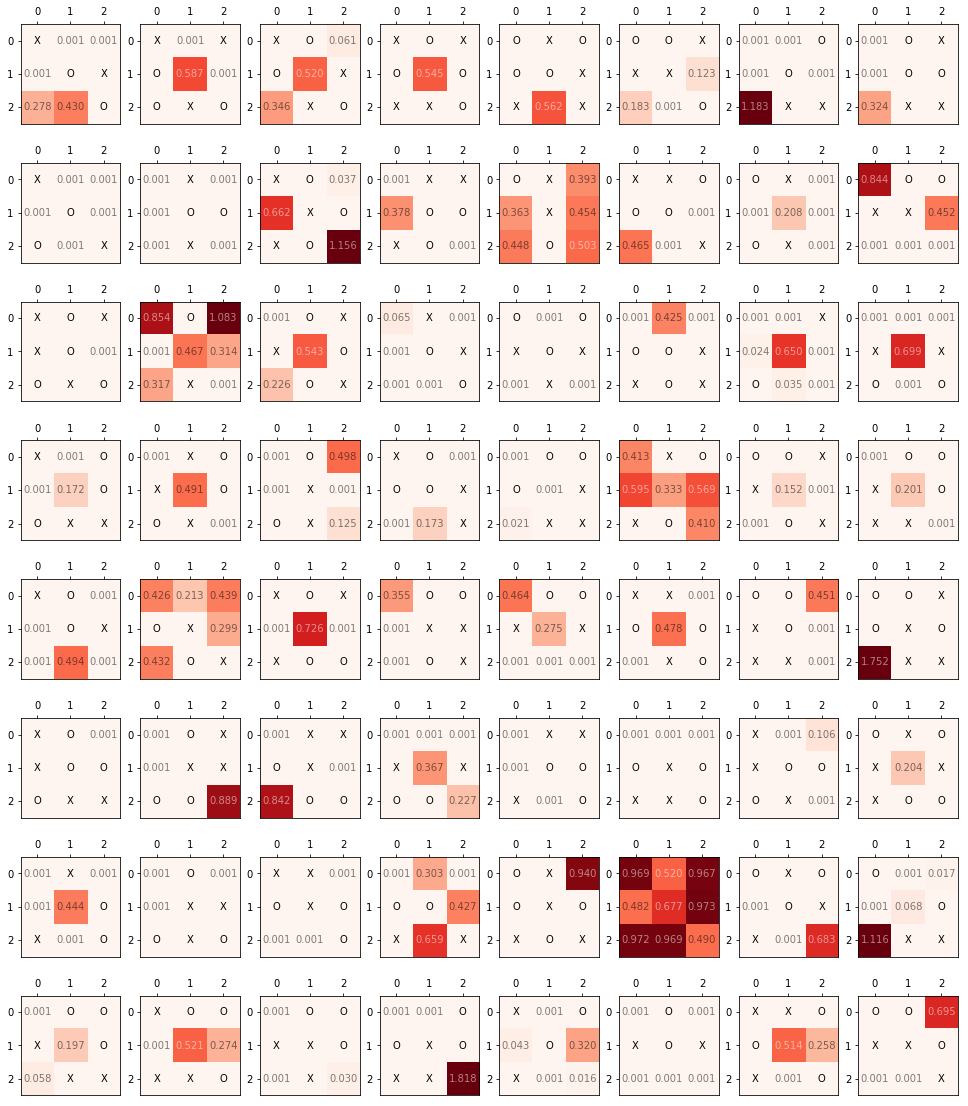

In [0]:
dqn.eval()
plot_dqs(dqn, num=(8,8))